# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [35]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

sample_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.25))
print(f"No. training samples (sampled classes): {len(sample_df)}")


No. training samples (all classes): 48652
No. training samples (sampled classes): 12164


In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [39]:
train_df, test_df = train_test_split(sample_df, test_size=0.2, stratify=sample_df["label"], random_state=42)
train_df.size, test_df.size

(19462, 4866)

In [40]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset

Dataset({
    features: ['label', 'text', '__index_level_0__', '__index_level_1__'],
    num_rows: 9731
})

In [41]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train

Dataset({
    features: ['label', 'text', '__index_level_0__', '__index_level_1__', 'input_ids', 'attention_mask'],
    num_rows: 9731
})

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [22]:
import evaluate

accuracy = evaluate.load("accuracy")

In [23]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [24]:
id2label = {1: "satire", 2: "hoax", 3: "propaganda", 4:"reliable"}
label2id = {"satire": 1, "hoax": 2, "propaganda": 3, "reliable": 4}

In [42]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 30
batches_per_epoch = len(tokenized_train) // batch_size
batches_per_epoch = len(tokenized_test) // batch_size

total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [29]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

2023-04-05 13:56:46.495476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 13:56:46.508230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [43]:
tf_train_set = model.prepare_tf_dataset(
    # tokenized_text["train"],
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [44]:
import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [45]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [48]:
callbacks = [metric_callback]

In [49]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3


2023-04-05 14:17:35.441919: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 14:17:40.102278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 34/608 [>.............................] - ETA: 3:07:25 - loss: 0.8991

KeyboardInterrupt: 

## Validation

In [ ]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model)
classifier(text)

In [75]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
759,2,"Michele Bachmann - Johnson, Obama Want To Stea..."
974,2,State Department Had No Inspector General Duri...
2190,3,Tweet (NewsTarget) Osteoporosis is a conditio...
2066,3,Oxidative stress is a constant force in our e...
771,2,Greatest Dad Wins Ever! You Wont Believe this ...


In [76]:
X_val = test_df['text'].values
y_val = test_df['label'].values

# Do the same preprocessing steps as training data: preprocess, tokenize, pad sequences
X_val = [preprocess(sentence) for sentence in X_val]
X_val = [tokenize(sentence) for sentence in X_val]
print("After:", X_val[0])


After: ['when', 'so', 'many', 'actor', 'seem', 'content', 'to', 'churn', 'out', 'performance', 'for', 'a', 'quick', 'paycheck', 'a', 'performer', 'who', 'adheres', 'to', 'his', 'principle', 'really', 'stand', 'out', 'thats', 'why', 'jeff', 'bridge', 'made', 'wave', 'this', 'week', 'when', 'he', 'announced', 'that', 'from', 'now', 'on', 'he', 'will', 'only', 'perform', 'nude', 'scene', 'in', 'an', 'interview', 'in', 'this', 'month', 'gq', 'the', 'big', 'lebowski', 'star', 'made', 'it', 'clear', 'that', 'he', 'wa', 'more', 'than', 'ready', 'to', 'move', 'on', 'to', 'a', 'new', 'phase', 'in', 'his', 'career', 'leaving', 'his', 'clothed', 'role', 'in', 'the', 'past', 'ive', 'been', 'there', 'and', 'ive', 'done', 'that', 'said', 'bridge', 'rattling', 'off', 'a', 'laundry', 'list', 'of', 'the', 'film', 'he', 'appeared', 'in', 'covered', 'up', 'now', 'i', 'can', 'finally', 'afford', 'to', 'only', 'take', 'on', 'role', 'that', 'excite', 'me', 'right', 'now', 'those', 'are', 'role', 'with', 'nu

In [77]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
len(X_val[0])

789

In [78]:
y_pred = model.predict(X_val)
predicted_indexes = np.argmax(y_pred, axis=1)
y_pred_val = [pred_class + 1 for pred_class in predicted_indexes]
y_pred_val

2023-04-05 13:20:10.329734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 2s 13ms/step


[1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 4,
 3,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,


In [79]:
# y_pred_val = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.5513333333333333
F1 score: 0.5286294512345218


In [80]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.45      0.84      0.59       750
        hoax       0.79      0.21      0.33       750
  propaganda       0.53      0.52      0.53       750
    reliable       0.71      0.64      0.67       750

    accuracy                           0.55      3000
   macro avg       0.62      0.55      0.53      3000
weighted avg       0.62      0.55      0.53      3000



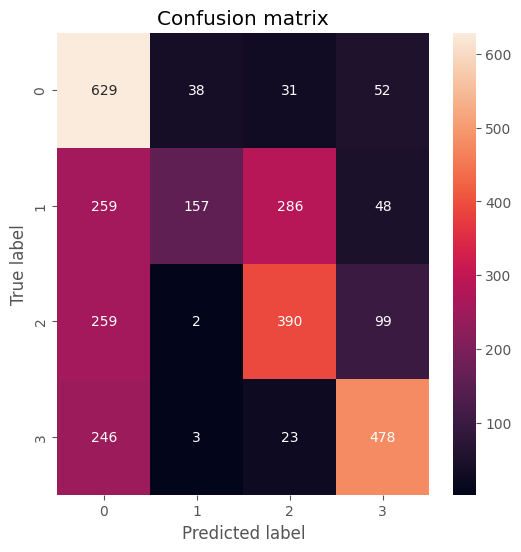

In [81]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	